In [1]:
import sys
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
import numpy as np
import pandas as pd
import os
import random
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from category_encoders import CountEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

# read datasets

In [3]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
train_drug = pd.read_csv("../input/lish-moa/train_drug.csv")

data = train_features.append(test_features)

ss = pd.read_csv('../input/lish-moa/sample_submission.csv')

# main parameters 

from https://www.kaggle.com/vbmokin/moa-pytorch-rankgauss-pca-nn-upgrade-3d-visual


In [4]:
n_comp_GENES = 463
n_comp_CELLS = 60
VarianceThreshold_for_FS = 0.9
NFOLDS = 5

# set seeds

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# transform columns to normal dist with rankgauss (QuantileTransformer)

In [6]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [7]:
col_names = GENES + CELLS
col_example_index = 300
col_example_name = col_names[300]

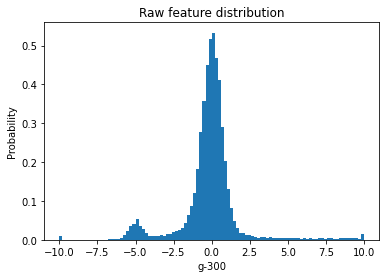

In [8]:
fig = plt.figure()
plt.hist(train_features.iloc[:,col_example_index+4].values, bins=100, density= True)
plt.ylabel('Probability')
plt.xlabel(col_example_name)
plt.title('Raw feature distribution');

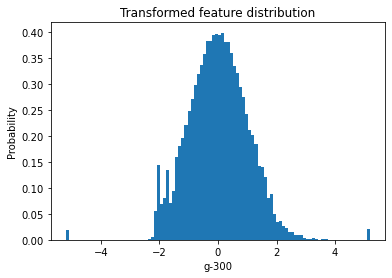

In [9]:
transformer = QuantileTransformer(n_quantiles=50,random_state=0, output_distribution="normal")
fig = plt.figure()
plt.hist(transformer.fit_transform(train_features.iloc[:,col_example_index+4].values.reshape(-1,1)), bins=100, density= True)

plt.ylabel('Probability')
plt.xlabel(col_example_name)
plt.title('Transformed feature distribution');

In [10]:
# quantile transformer normal dist --> 
for col in (GENES + CELLS):    
    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

# dimensionality reduction with pca 

In [11]:
len(GENES)

772

In [12]:
# GENES

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp_GENES, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [13]:
len(CELLS)

100

In [14]:
# CELLS

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp_CELLS, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [15]:
train_features.shape[1]

1399

In [16]:
train_features.head(5)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,pca_C-50,pca_C-51,pca_C-52,pca_C-53,pca_C-54,pca_C-55,pca_C-56,pca_C-57,pca_C-58,pca_C-59
0,id_000644bb2,trt_cp,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,...,-0.514146,0.727106,0.631370,0.588790,-0.623881,-0.584221,0.139658,-0.748875,-0.090711,0.508949
1,id_000779bfc,trt_cp,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,...,-1.439262,0.508808,1.712656,-0.095448,-0.052959,-0.427382,-0.789533,-0.677906,-0.006642,0.581791
2,id_000a6266a,trt_cp,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,...,-0.491030,0.259354,-0.724947,0.138275,-0.128793,-1.059011,-1.629201,0.177806,-0.776725,-0.204851
3,id_0015fd391,trt_cp,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,...,0.545759,0.197091,-0.058694,0.616253,-0.000931,0.135783,-0.326965,0.131044,0.061892,-0.054619
4,id_001626bd3,trt_cp,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,...,0.774619,0.630446,0.514879,-0.217948,-0.435192,0.350271,-2.249275,-1.029288,0.098284,-0.397215


# feature elimination with variance threshold

In [17]:
data = train_features.append(test_features)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,pca_C-50,pca_C-51,pca_C-52,pca_C-53,pca_C-54,pca_C-55,pca_C-56,pca_C-57,pca_C-58,pca_C-59
0,id_000644bb2,trt_cp,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,...,-0.514146,0.727106,0.631370,0.588790,-0.623881,-0.584221,0.139658,-0.748875,-0.090711,0.508949
1,id_000779bfc,trt_cp,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,...,-1.439262,0.508808,1.712656,-0.095448,-0.052959,-0.427382,-0.789533,-0.677906,-0.006642,0.581791
2,id_000a6266a,trt_cp,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,...,-0.491030,0.259354,-0.724947,0.138275,-0.128793,-1.059011,-1.629201,0.177806,-0.776725,-0.204851
3,id_0015fd391,trt_cp,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,...,0.545759,0.197091,-0.058694,0.616253,-0.000931,0.135783,-0.326965,0.131044,0.061892,-0.054619
4,id_001626bd3,trt_cp,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,...,0.774619,0.630446,0.514879,-0.217948,-0.435192,0.350271,-2.249275,-1.029288,0.098284,-0.397215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,trt_cp,24,D1,0.599272,-0.691298,2.335275,-0.965903,1.073011,1.784340,...,0.547616,0.375451,-0.789073,0.444972,-0.369285,-0.345567,-0.836058,-0.262109,-0.338685,0.761653
3978,id_ff925dd0d,trt_cp,24,D1,-0.844395,-0.282043,2.006827,0.507512,0.643034,0.434686,...,-0.182719,0.482303,-0.059722,-0.447048,0.031236,-0.097593,1.001712,-0.248932,0.681888,1.311962
3979,id_ffb710450,trt_cp,72,D1,-0.563702,-0.146343,0.232721,-1.052568,0.066341,0.635259,...,0.365366,-0.406966,0.172072,-0.337644,0.337394,-0.835286,0.458107,0.592310,-0.137111,0.143073
3980,id_ffbb869f2,trt_cp,48,D2,-1.591078,-1.924736,-0.619409,1.321092,-1.622643,-0.263479,...,1.210053,0.023657,0.814503,-0.778416,0.715037,0.284688,-1.656575,-0.538254,-1.241811,-0.748269


In [18]:
var_thresh = VarianceThreshold(VarianceThreshold_for_FS)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

train_features.shape

(23814, 1014)

In [19]:
train_features.head(5)

,sig_id,cp_type,cp_time,cp_dose,0,1,2,3,4,5,...,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009
0,id_000644bb2,trt_cp,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,...,-1.664511,0.850912,-1.954714,4.877738,1.539579,-1.558672,1.128901,0.913540,-1.087465,0.303792
1,id_000779bfc,trt_cp,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,...,-0.027446,0.081617,0.540991,5.049432,-0.354706,0.010856,1.013321,-0.502233,0.711812,0.225988
2,id_000a6266a,trt_cp,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,...,0.047053,1.384234,0.498396,-1.391302,0.309869,-0.278836,-0.191459,-0.086282,-0.680219,-0.883705
3,id_0015fd391,trt_cp,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,...,0.196117,-0.745072,0.045870,-10.972282,1.157498,-0.947954,-1.585535,0.019060,-1.261338,0.387432
4,id_001626bd3,trt_cp,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,...,0.602852,2.202714,0.777727,3.599316,0.556439,-0.668258,-0.301835,0.302974,0.206142,-0.301955


# create datasets

In [20]:
# merge feature and and targets
merged = train_features.merge(train_targets_scored, on='sig_id')

# remove ctl_vehicle rows
merged = merged[merged['cp_type']!='ctl_vehicle'].reset_index(drop=True)
X_test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

# create X_train and y_train
X_train = merged[train_features.columns]
y_train = merged[train_targets_scored.columns]

In [21]:
# drop cp_type column
X_train = X_train.drop('cp_type', axis=1)
X_test = X_test.drop('cp_type', axis=1)

In [22]:
# drop sig_id column
X_train = X_train.drop('sig_id', axis=1)
X_test = X_test.drop('sig_id', axis=1)
y_train = y_train.drop('sig_id', axis=1)

In [23]:
X_train.head(5)

,cp_time,cp_dose,0,1,2,3,4,5,6,7,...,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009
0,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,...,-1.664511,0.850912,-1.954714,4.877738,1.539579,-1.558672,1.128901,0.913540,-1.087465,0.303792
1,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,...,-0.027446,0.081617,0.540991,5.049432,-0.354706,0.010856,1.013321,-0.502233,0.711812,0.225988
2,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,...,0.047053,1.384234,0.498396,-1.391302,0.309869,-0.278836,-0.191459,-0.086282,-0.680219,-0.883705
3,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,0.309275,...,0.196117,-0.745072,0.045870,-10.972282,1.157498,-0.947954,-1.585535,0.019060,-1.261338,0.387432
4,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,-0.205867,...,0.602852,2.202714,0.777727,3.599316,0.556439,-0.668258,-0.301835,0.302974,0.206142,-0.301955


# XGBoost with CountEncoder

In [24]:
classifier = MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist'))
#classifier = MultiOutputClassifier(XGBClassifier())

clf = Pipeline([('encode', CountEncoder(cols=["cp_dose","cp_time"])),
                ('classify', classifier)
               ])

# CV predictions with MultilabelStratifiedKFold

In [25]:
oof_preds = np.zeros(y_train.shape)
test_preds = np.zeros((X_test.shape[0], y_train.shape[1]))
oof_losses = []
mskf = MultilabelStratifiedKFold(n_splits=NFOLDS, random_state=42)
for fn, (trn_idx, val_idx) in enumerate(mskf.split(X_train, y_train)):
    print('Starting fold: ', fn)
    X_trn, X_val = X_train.iloc[trn_idx,:], X_train.iloc[val_idx,:]
    y_trn, y_val = y_train.iloc[trn_idx,:], y_train.iloc[val_idx,:]
    
    clf.fit(X_trn, y_trn)
    val_preds = clf.predict_proba(X_val) # list of preds per class
    val_preds = np.array(val_preds)[:,:,1].T # take the positive class
    oof_preds[val_idx] = val_preds
    
    loss = log_loss(np.ravel(y_val), np.ravel(val_preds))
    oof_losses.append(loss)
    preds = clf.predict_proba(X_test)
    preds = np.array(preds)[:,:,1].T # take the positive class
    test_preds += preds / NFOLDS
    
print(oof_losses)
print('Mean OOF loss across folds', np.mean(oof_losses))
print('STD OOF loss across folds', np.std(oof_losses))

Starting fold:  0
Starting fold:  1
Starting fold:  2
Starting fold:  3
Starting fold:  4
[0.024061227940014317, 0.02433675124618263, 0.024202732004484775, 0.024545425003294725, 0.024049355829841326]
Mean OOF loss across folds 0.024239098404763553
STD OOF loss across folds 0.00018565275351707533


In [26]:
print('OOF log loss: ', log_loss(np.ravel(y_train), np.ravel(oof_preds)))

OOF log loss:  0.02423910244938239


# Analysis of OOF preds

In [27]:
# set control test preds to 0
control_mask = test_features['cp_type']!='ctl_vehicle'

dummy_preds = np.zeros((ss.shape[0],ss.shape[1]-1))
dummy_preds[control_mask] = test_preds

In [28]:
# create the submission file
ss.iloc[:,1:] = dummy_preds
ss.to_csv('submission.csv', index=False)